In [1]:
import os
import numpy as np
import cv2 # OpenCV
from sklearn.svm import SVC # SVM klasifikator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN
from joblib import dump, load
import matplotlib
import matplotlib.pyplot as plt
import sys
from sklearn.utils import shuffle
from datetime import datetime


from imutils import face_utils
import argparse
import imutils
import dlib

%matplotlib inline

In [2]:
# inicijalizaclija dlib detektora (HOG)
detector = dlib.get_frontal_face_detector()
# ucitavanje pretreniranog modela za prepoznavanje karakteristicnih tacaka
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

def reshape_data(input_data):
    nsamples, nx, ny = input_data.shape
    return input_data.reshape((nsamples, nx*ny))

In [5]:
try:
    detekcija = load('model/detekcija.joblib')
    print('ucitan modeli')
except Exception as e:
    detekcija = None
    
if detekcija == None:

    X = []
    labels = []

    nbins = 9  # broj binova
    cell_size = (8, 8)  # broj piksela po celiji
    block_size = (3, 3)  # broj celija po bloku

    dim = (176, 176)

    for image_name in os.listdir('dataset/without_mask'):
        image = load_image('dataset/without_mask/' + image_name)
        rects = detector(image, 1)

        for (b, rect) in enumerate(rects):

            shape = predictor(image, rect)
            shape = face_utils.shape_to_np(shape)


            (x, y, w, h) = face_utils.rect_to_bb(rect)

        roi = image[y:y + h, x:x + w]

        resized = cv2.resize(roi, dim)

        hog = cv2.HOGDescriptor(_winSize=(resized.shape[1] // cell_size[1] * cell_size[1],
                                          resized.shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)

        X.append(hog.compute(resized))
        labels.append(0)

#     for image_name in os.listdir('dataset/as'):
#         image = load_image('dataset/as/' + image_name)
#         resized = cv2.resize(image, dim)

#         hog = cv2.HOGDescriptor(_winSize=(resized.shape[1] // cell_size[1] * cell_size[1],
#                                           resized.shape[0] // cell_size[0] * cell_size[0]),
#                                 _blockSize=(block_size[1] * cell_size[1],
#                                             block_size[0] * cell_size[0]),
#                                 _blockStride=(cell_size[1], cell_size[0]),
#                                 _cellSize=(cell_size[1], cell_size[0]),
#                                 _nbins=nbins)

#         X.append(hog.compute(resized))
#         labels.append(1)

    for image_name in os.listdir('dataset/with_mask'):
        image1 = load_image('dataset/with_mask/' + image_name)

        rects = detector(image1, 1)

        for (b, rect) in enumerate(rects):

            shape = predictor(image1, rect)
            shape = face_utils.shape_to_np(shape)


            (x, y, w, h) = face_utils.rect_to_bb(rect)

        roi = image1[y:y + h, x:x + w]


        resiz = cv2.resize(roi, dim)
        hog = cv2.HOGDescriptor(_winSize=(resiz.shape[1] // cell_size[1] * cell_size[1],
                                          resiz.shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)

        X.append(hog.compute(resiz))
        labels.append(1)


    X=np.array(X)
    Y=np.array(labels)
    X=reshape_data(X)

    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2)

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)   

    print('treniranje modela za detekciju zapoceto')
    detekcija = SVC(kernel='linear', gamma='scale', probability=True)
    detekcija.fit(X_train,y_train)

    dump(detekcija, 'model/detekcija.joblib')
    print('treniranje modela za klasifikaciju zavrseno')




ucitan modeli


In [8]:

from sklearn import metrics
y_pred = detekcija.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.9947368421052631


In [9]:
from sklearn.metrics import classification_report 
pred = detekcija.predict(X_test)

target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      0.99      1.00       107
     class 1       0.99      1.00      0.99        83

    accuracy                           0.99       190
   macro avg       0.99      1.00      0.99       190
weighted avg       0.99      0.99      0.99       190



In [5]:
cap = cv2.VideoCapture(0)


nbins = 9  # broj binova
cell_size = (8, 8)  # broj piksela po celiji
block_size = (3, 3)  # broj celija po bloku

dim = (176, 176)


while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    features = [];

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    for (b, rect) in enumerate(rects):

        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        
        (xosa, yosa, w, h) = face_utils.rect_to_bb(rect)
        face = frame[yosa:yosa + h, xosa:xosa + w]
           
    resized = cv2.resize(face, dim)

    hog = cv2.HOGDescriptor(_winSize=(resized.shape[1] // cell_size[1] * cell_size[1],
                          resized.shape[0] // cell_size[0] * cell_size[0]),
                _blockSize=(block_size[1] * cell_size[1],
                            block_size[0] * cell_size[0]),
                _blockStride=(cell_size[1], cell_size[0]),
                _cellSize=(cell_size[1], cell_size[0]),
                _nbins=nbins)

    features.append(hog.compute(resized))

    x = np.array(features)

    x_train = reshape_data(x)

    facial_expression = detekcija.predict(x_train)

#     print(facial_expression)

    if facial_expression[0] == 0:
        cv2.rectangle(frame, (xosa, yosa), (xosa + w, yosa + h), (0, 0, 255), 2)
        cv2.putText(frame, "without mask", (xosa, yosa),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    else:
        cv2.rectangle(frame, (xosa, yosa), (xosa + w, yosa + h), (0, 255, 0), 2)
        cv2.putText(frame, "with mask", (xosa, yosa),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

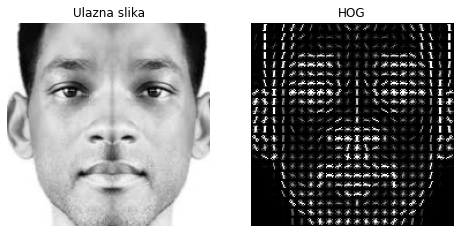

In [30]:
img = cv2.imread('dataset/without_mask/210.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

features = [];
nbins = 9  # broj binova
cell_size = (8, 8)  # broj piksela po celiji
block_size = (3, 3)  # broj celija po bloku

dim = (176, 176)
rects = detector(gray, 1)

for (b, rect) in enumerate(rects):

    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    (xosa, yosa, w, h) = face_utils.rect_to_bb(rect)
    face = gray[yosa:yosa + h, xosa:xosa + w]

resized = cv2.resize(face, dim)

hog = cv2.HOGDescriptor(_winSize=(resized.shape[1] // cell_size[1] * cell_size[1],
                      resized.shape[0] // cell_size[0] * cell_size[0]),
            _blockSize=(block_size[1] * cell_size[1],
                        block_size[0] * cell_size[0]),
            _blockStride=(cell_size[1], cell_size[0]),
            _cellSize=(cell_size[1], cell_size[0]),
            _nbins=nbins)


# features.append(hog.compute(resized))







from skimage.feature import hog
from skimage import data, exposure

fd, hog_image = hog(resized, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(3, 3), visualize=True, multichannel=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(resized, cmap=plt.cm.gray)
ax1.set_title('Ulazna slika')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG')
plt.show()

# x = np.array(features)

# x_train = reshape_data(x)

# facial_expression = detekcija.predict(x_train)

# if facial_expression[0] == 0:
#     print('nema masku')
# else:
#     print('ima masku')
    
# plt.imshow(img)

In [7]:
file=open('dataset/annotations.csv')
data = file.read()
lines = data.split('\n')
facial_expression=[]
br_tacnih=0
ukupno=0
before = datetime.now()
nbins = 9  # broj binova
cell_size = (8, 8)  # broj piksela po celiji
block_size = (3, 3)  # broj celija po bloku

dim = (176, 176)
for index, line in enumerate(lines):
    cols = line.split(',')
    if cols and cols[0] == '':
        continue
    cols[0] = cols[0].replace('\r', '')
    cols[1] = cols[1].replace('\r', '')

    image = load_image('dataset/test/' + cols[0])

    features = [];

    rects = detector(image, 1)

    for (b, rect) in enumerate(rects):

        shape = predictor(image, rect)
        shape = face_utils.shape_to_np(shape)

        (xosa, yosa, w, h) = face_utils.rect_to_bb(rect)
        face = image[yosa:yosa + h, xosa:xosa + w]

    resized = cv2.resize(face, dim)

    hog = cv2.HOGDescriptor(_winSize=(resized.shape[1] // cell_size[1] * cell_size[1],
                          resized.shape[0] // cell_size[0] * cell_size[0]),
                _blockSize=(block_size[1] * cell_size[1],
                            block_size[0] * cell_size[0]),
                _blockStride=(cell_size[1], cell_size[0]),
                _cellSize=(cell_size[1], cell_size[0]),
                _nbins=nbins)

    features.append(hog.compute(resized))

    x = np.array(features)

    x_train = reshape_data(x)

    ukupno+=1
    if int(detekcija.predict(x_train)[0]) == int(cols[1]):
        br_tacnih+=1
after = datetime.now()
#     print(cols[1])
#     print(detekcija.predict(x_train)[0])
#     print(cols[0])
#     print('---------------')
    
    
print('Tacnost: '+ str(br_tacnih/ukupno*100))
print('Ukupno vreme: '+ str(after-before))

Tacnost: 81.25
Ukupno vreme: 0:00:02.286708
